In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Downloading Data


In [ ]:
!mkdir ~/.kaggle
!echo '{"username":"shamsivakumar","key":"f15dc528ba4a870e0fdb160c5c944fbf"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 99% 329M/331M [00:02<00:00, 139MB/s]
100% 331M/331M [00:02<00:00, 157MB/s]


In [ ]:
!unzip -q utkface-new.zip

# Importing Library

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image,ImageOps
from IPython.display import display
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.utils import plot_model

# Loading Data

In [ ]:
IMAGE_PATH  = "/content/crop_part1"
DSIZE = 4000
print("The number of images in the original dataset = ",len(os.listdir(IMAGE_PATH)))

The number of images in the original dataset =  9780


In [ ]:
def read_image(path):
    img = Image.open(path)
    return img
IMAGE_NAMES = os.listdir(IMAGE_PATH)[:DSIZE]
AGES = [int(i.split('_')[0]) for i in IMAGE_NAMES]
GENDERS = [int(i.split('_')[1]) for i in IMAGE_NAMES]
IMAGES = [read_image(IMAGE_PATH + '/' + i) for i in IMAGE_NAMES]
print("The number of images read = ",len(IMAGES))

The number of images read =  4000


In [ ]:
data = {
    'image': IMAGES,
    'age': AGES,
    'gender': GENDERS
}
df = pd.DataFrame(data,columns = ['image','age','gender'])
df

,image,age,gender
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,50,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,50,1
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,32,1
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,68,0
...,...,...,...
3995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,20,1
3996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,7,1
3997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,49,0
3998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,53,1


In [ ]:
print("The shape of the dataframe is" ,df.shape)

The shape of the dataframe is (4000, 3)


The size of the image =  (200, 200)


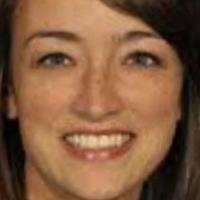

29 1


In [ ]:
rindex = random.randint(0, len(df))
print("The size of the image = ",df['image'][rindex].size)
display(df['image'][rindex])
print(df['age'][rindex], df['gender'][rindex])

Gender Label :0 corresponds to male, 1 corresponds to female.

# Data Visualization

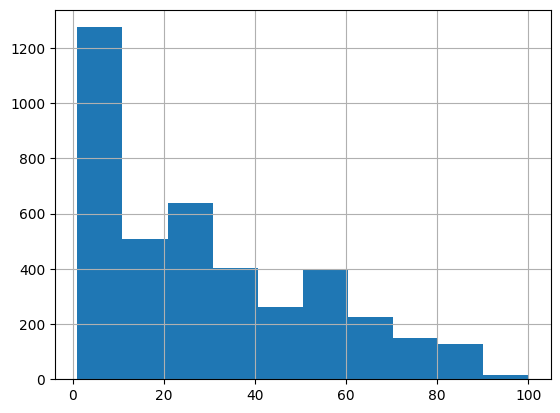

In [ ]:
df['age'].hist()
plt.show()

In [ ]:
age_distribution = df['age']
age_distribution.value_counts().sort_index()

age
1      453
2      202
3      110
4      109
5       76
      ... 
92       4
93       1
95       1
96       8
100      1
Name: count, Length: 95, dtype: int64

As from the age distribution , we can see that the data contains mostly of people with age 1, this could result to overfitting of model in these age range. So to avoid this, we sample the sub part of the data

In [ ]:
underage = []

underage1 = df[df['age'] == 1]
underage1_sample = underage1.sample(frac=0.2)
underage2 = df[df['age'] == 2]
underage2_sample = underage2.sample(frac=0.4)
df_over4 = df[df['age'] > 2]

df = pd.concat([df_over4, underage1_sample,underage2_sample], ignore_index=True)

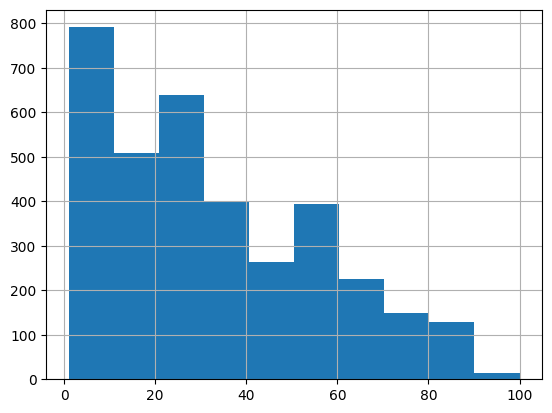

In [ ]:
df['age'].hist()
plt.show()

This looks much better! The dataframe is more representative of the population now. However, there aren't many images of people over 80, which would cause the model to not train well enough on those ages. So either we can distribute the images over all evenly or we could just remove the above 80s part and the model would work fine

In [ ]:
df = df[df['age'] < 80]

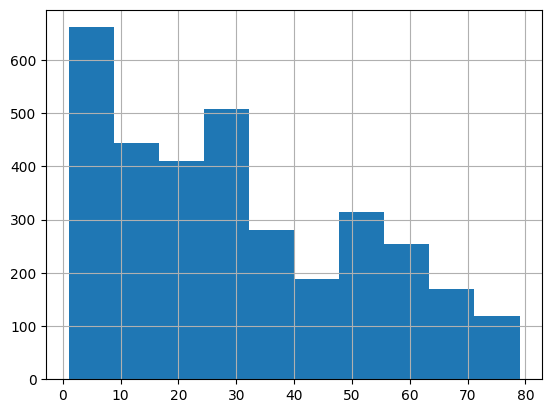

In [ ]:
df['age'].hist()
plt.show()

In [ ]:
df['gender'].value_counts()

gender
1    1920
0    1427
3       1
Name: count, dtype: int64

Not sure what 3 corresponds to - both genders, no gender, unknown, or just an error in the data entry? To be safe, I am going to remove any rows where gender equals 3.

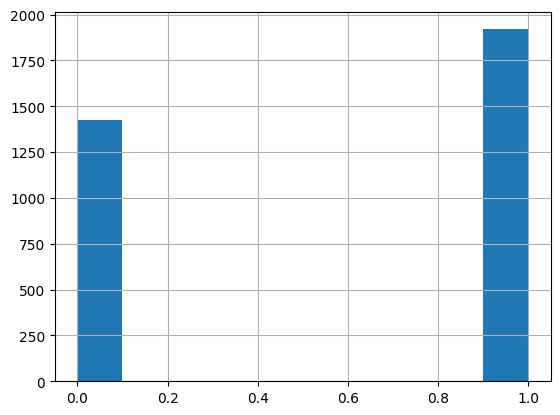

In [ ]:
df = df[df['gender'] != 3]
df['gender'].hist()
plt.show()

Resizing images so that the model can fit faster
200 X 200 would be a apt size for fitting

In [ ]:
import warnings
warnings.filterwarnings('ignore')
x = []

for i in range(len(df)):
    df['image'].iloc[i] = df['image'].iloc[i].resize((200,200), Image.Resampling.LANCZOS)
    ar = np.asarray(df['image'].iloc[i])
    x.append(ar)
x = np.array(x)

In [ ]:
y = df[['age', 'gender']]

In [ ]:
y


,age,gender
0,50,0
1,50,1
2,32,1
3,68,0
4,39,1
...,...,...
2639,2,1
2640,2,1
2641,2,1
2642,2,1


# Preparation of Training Data

In [ ]:
y_age = y['age']
y_gender = y['gender']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2,stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2,stratify=y_age)

In [ ]:
print("The length of training data = ",len(x_train_age))
print("The length of testing data = ",len(x_test_age))

The length of training data =  2677
The length of testing data =  670


# Creating the models

I will create two individual models - one to predict age and one to predict gender. The age model should be capable of returning continuous values which I will round to the nearest integer, and the gender model should return a binary result.

Defining each model for age and gender because multi output neural model can lead to complex logic which can reduce the overall performance

In [ ]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3),name='inputAge'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu',name='ageOut'))

agemodel.compile(loss='mean_squared_error',
             optimizer=optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3),name='inputGender'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid',name = 'genderOut'))

genmodel.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(learning_rate=0.0001),
             metrics=['accuracy'])

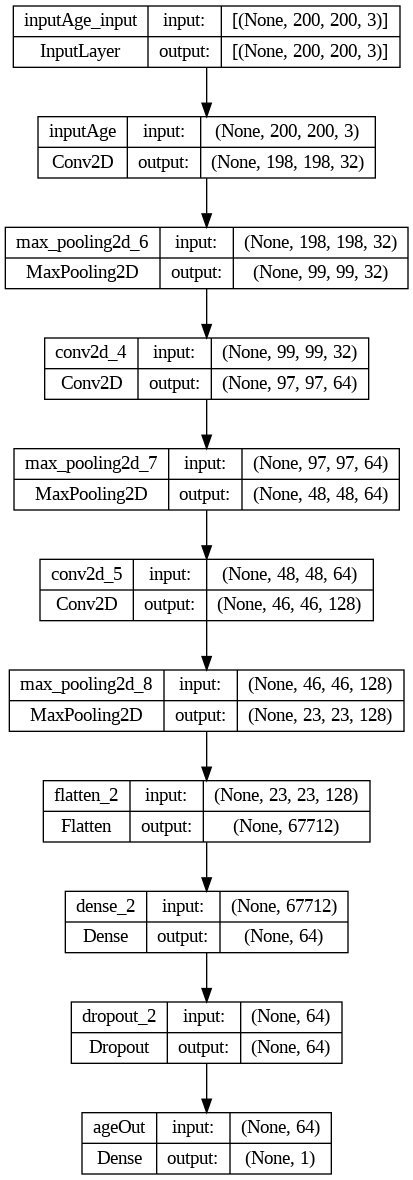

In [ ]:
plot_model(agemodel,show_shapes= True,show_layer_names=True)

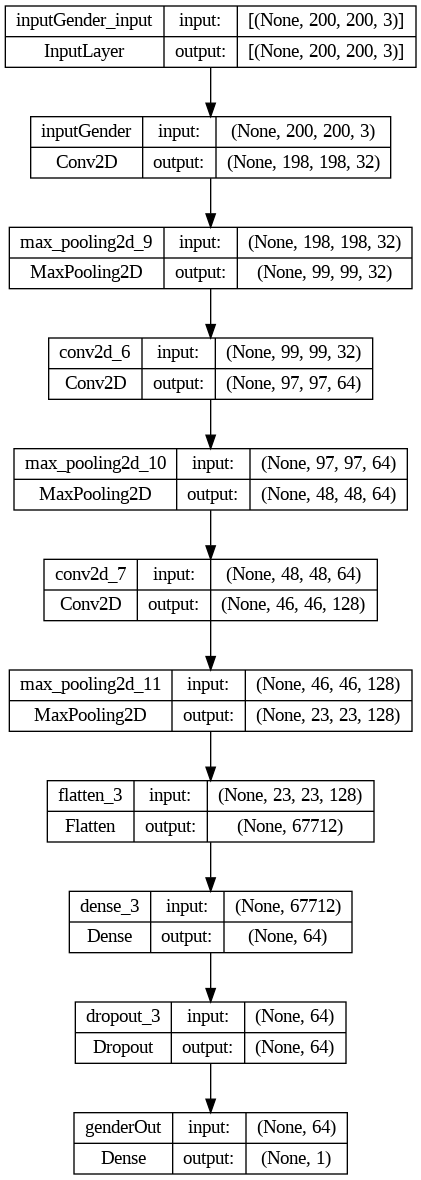

In [ ]:
plot_model(genmodel,show_shapes= True)

# Training the Models

## Training the age model

In [ ]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_age, y_train_age, batch_size=64)

test1 = test_datagen.flow(
       x_test_age, y_test_age,
       batch_size=64)

history1 = agemodel.fit(train1, epochs=5, shuffle=True, validation_data=test1)

Epoch 1/5
42/42 [==============================] - 302s 7s/step - loss: 724.9083 - accuracy: 0.0265 - val_loss: 494.2121 - val_accuracy: 0.0269
Epoch 2/5
42/42 [==============================] - 293s 7s/step - loss: 537.2293 - accuracy: 0.0273 - val_loss: 469.0833 - val_accuracy: 0.0269
Epoch 3/5
42/42 [==============================] - 301s 7s/step - loss: 500.1347 - accuracy: 0.0273 - val_loss: 468.6903 - val_accuracy: 0.0269
Epoch 4/5
42/42 [==============================] - 294s 7s/step - loss: 492.1216 - accuracy: 0.0273 - val_loss: 439.5724 - val_accuracy: 0.0269
Epoch 5/5
42/42 [==============================] - ETA: 0s - loss: 460.0412 - accuracy: 0.0273

Saving the model to google drive

In [ ]:
agemodel.save('/content/drive/MyDrive/agemodel.h5')

## Training the gender model

In [ ]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=64)

test2 = test_datagen.flow(
        x_test_gender, y_test_gender,
        batch_size=64)

history2 = genmodel.fit(train2, epochs=5, shuffle=True, validation_data=test2)

Epoch 1/5
32/32 [==============================] - 222s 7s/step - loss: 0.6600 - accuracy: 0.6093 - val_loss: 0.6178 - val_accuracy: 0.6290
Epoch 2/5
32/32 [==============================] - 218s 7s/step - loss: 0.6199 - accuracy: 0.6660 - val_loss: 0.6023 - val_accuracy: 0.6468
Epoch 3/5
32/32 [==============================] - 211s 7s/step - loss: 0.6143 - accuracy: 0.6655 - val_loss: 0.5957 - val_accuracy: 0.6865
Epoch 4/5
32/32 [==============================] - 209s 6s/step - loss: 0.5843 - accuracy: 0.6928 - val_loss: 0.5686 - val_accuracy: 0.6944
Epoch 5/5
32/32 [==============================] - 204s 6s/step - loss: 0.5684 - accuracy: 0.7073 - val_loss: 0.5540 - val_accuracy: 0.7183


In [ ]:
genmodel.save('/content/drive/MyDrive/genmodel.h5')

# Evaluating the training performance

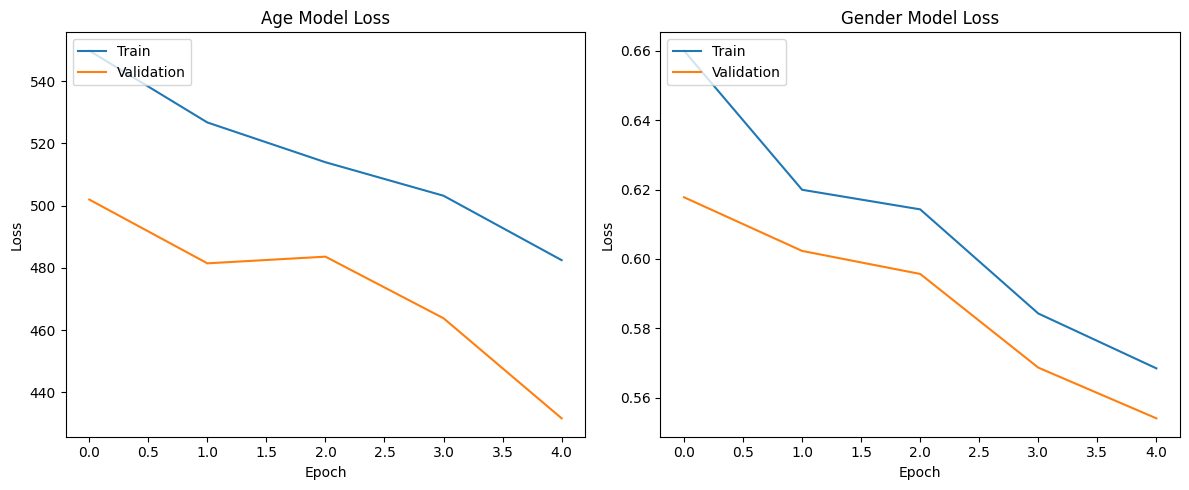

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history1.history['loss'])
ax1.plot(history1.history['val_loss'])
ax1.set_title('Age Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(history2.history['loss'])
ax2.plot(history2.history['val_loss'])
ax2.set_title('Gender Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Evaluating the results

Now to evaluate the models I am going to use some external images of celebrities. These celebrities are of a variety of ages and genders.

In [ ]:
del agemodel,genmodel

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
agemodel = load_model('/content/drive/MyDrive/agemodel.h5')
genmodel = load_model('/content/drive/MyDrive/genmodel.h5')

In [ ]:
TEST_IMAGE_PATH = '/content/UTKFace/'
def process_and_predict(file):
    AGE, GENDER = file.split('_')[0], file.split('_')[1]
    GENDER = 'male' if GENDER == '0' else 'female'
    im = Image.open(TEST_IMAGE_PATH + file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.Resampling.LANCZOS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.Resampling.LANCZOS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200),Image.Resampling.LANCZOS)

    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)

    age = agemodel.predict(ar)
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'

    print('Actual Age:', int(AGE), '\nPredicted Gender:', GENDER)
    print('Predicted Age:', int(age), '\nPredicted Gender:', gender)
    return im.resize((300,300), Image.Resampling.LANCZOS)

# Verifying the result

1/1 [==============================] - 0s 40ms/step
Actual Age: 71 
Predicted Gender: male
Predicted Age: 28 
Predicted Gender: female


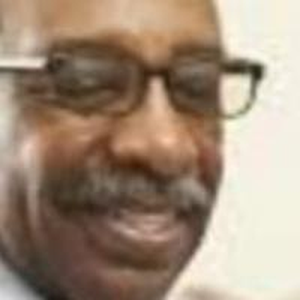

In [ ]:
RFILE = random.choice(os.listdir(TEST_IMAGE_PATH))
process_and_predict(RFILE)